# Using Predictive Analytics to Predict Delays in Maritime Container Shipping

In [1]:
%matplotlib inline

**Import Libraries**

In [2]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from fuzzywuzzy import fuzz

import warnings
#https://github.com/pandas-dev/pandas/issues/8509
warnings.filterwarnings('ignore', 'numpy not_equal will not check object identity in the future')

#http://pythondata.com/dask-large-csv-python/
#import dask.dataframe as dd
 
#from collections import Counter
#from patsy import dmatrices
#import statsmodels.api as sm

#https://www.dataquest.io/blog/pandas-big-data/

## ** Consider Original Dataset **

In [3]:
#View original dataframe
df_orig = pd.read_pickle('2014_data.pkl')

In [4]:
#check the import
print df_orig.shape
df_orig.head()

(10816209, 24)


,identifier,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,container_number,description_sequence_number,piece_count,description_text,carrier,day_of_week_est,day_of_week_act,month_est,month_act,delay_days
0,2014082158845,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,TGHU8036820,1,7881,IKEA HOME FURNISHING PRODUCTS TARIFF NUMBER 44...,HYUNDAI,3,1,8,8,5
1,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,APZU3172532,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5
2,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,APZU3599329,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5
3,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,TRLU3176120,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5
4,2014082158983,2014-08-06,2014-08-21,OOCL SHENZHEN,"Long Beach, California",2014-08-19,"Yantian,China (Mainland)",New,"YANTIAN,CHINA",NaN,...,OOLU1064780,1,498,P.O.NO.050803/050938/051058/051197/051345/051 ...,OOCL,1,2,8,8,1


In [5]:
#Add a month column for estimated arrival date and actual arrival date
df_orig['month_est'] = df_orig.estimated_arrival_date.dt.month
df_orig['month_act'] = df_orig.actual_arrival_date.dt.month

In [6]:
temp = df_orig[(df_orig.month_act == 3) & (df_orig.vessel_name.str.contains('OAKLAND EXPRESS'))]

In [7]:
temp.to_csv('Oakland_Express.csv')

** Check for data anomolies **

In [8]:
#number of non-2014 actual or estimated arrival date observations
non_2014 = df_orig[(df_orig.actual_arrival_date.dt.year != 2014) | (df_orig.estimated_arrival_date.dt.year != 2014)]

In [9]:
#percent of observations that are not 2014
print len(non_2014), len(df_orig)
print round(len(non_2014) / (len(df_orig) * 1.0), 4)

136058 10816209
0.0126


Just over 1% of observations contain a non-2014 date, so non-2014 observations will be dropped from the dataset

** Create a dataframe that only has 2014 estimated and actual arrival dates **

In [10]:
#get non-2014 actual arrival date observations
df_orig_2014 = df_orig[(df_orig.actual_arrival_date.dt.year == 2014) &
                       (df_orig.estimated_arrival_date.dt.year == 2014)]

In [11]:
df_orig_2014.shape

(10680151, 24)

** Check if vessel_names are standardized, if not estimate the magnitude of the issue **

In [12]:
#get unique vessel_names and add a column for the revised vessel names
vessel_names = df_orig_2014[['vessel_name']].drop_duplicates()
vessel_names['vessel_name_new'] = vessel_names.vessel_name.copy()

In [13]:
vessel_names.head()

,vessel_name,vessel_name_new
0,HYUNDAI FORCE,HYUNDAI FORCE
4,OOCL SHENZHEN,OOCL SHENZHEN
5,HYUNDAI GLOBAL,HYUNDAI GLOBAL
7,COSCO HARMONY,COSCO HARMONY
12,MSC LORETTA,MSC LORETTA


In [14]:
#Remove whitespace, punctuation and extra spaces between words
vessel_names['vessel_name_new'] = vessel_names.vessel_name_new.str.strip()
vessel_names['vessel_name_new'] = vessel_names.vessel_name_new.str.replace('[^\w\s]','')
vessel_names['vessel_name_new'] = vessel_names.vessel_name_new.replace('\s+', ' ', regex=True)

In [15]:
#check the reduction in unique names
len(vessel_names.vessel_name.unique()), len(vessel_names.vessel_name_new.unique())

(9378, 8963)

Compare each row to the prior row: this assumes spelling differences are in the center of the name so sorting and comparing row to row will provide an indication of how pervasive the problem is

In [16]:
#sort the dataframe by vessel_name_new and create a new column that shifts vessel_name_new down 1 row
vessel_names.sort_values('vessel_name_new', inplace = True)
vessel_names['vnn_shift_1'] = vessel_names.vessel_name_new.shift()

In [17]:
vessel_names.head()

,vessel_name,vessel_name_new,vnn_shift_1
10230562,076W,076W,NaN
10965333,11169744,11169744,076W
1877120,1406,1406,11169744
4793505,2658840,2658840,1406
3015898,3 OAK,3 OAK,2658840


** Get the fuzz ratio between the ordered observations **

In [18]:
#get the fuzz ratio for vessel name and vessel name shifted down one place
fuzz_ratio = vessel_names.iloc[1:,:].apply(lambda x: fuzz.ratio(x['vessel_name_new'], x['vnn_shift_1']), axis = 1)

In [19]:
#convert fuzz_ratio from series to dataframe and merge with vessel_names
fuzz_ratio = fuzz_ratio.to_frame(name = 'fuzz_ratio')
vessel_names = vessel_names.merge(fuzz_ratio, left_index = True, right_index = True, how = "left")

In [20]:
#sort by fuzz_ratio
vessel_names.sort_values('fuzz_ratio',inplace = True)
vessel_names.head()

,vessel_name,vessel_name_new,vnn_shift_1,fuzz_ratio
5042996,U-861,U861,TYSON B,0.0
3015898,3 OAK,3 OAK,2658840,0.0
5125073,M 5001,M 5001,LYSIAS,0.0
8334,CHACABUCO,CHACABUCO,CGM NEW JERSEY,9.0
1638045,D2005,D2005,D SSELDORF EXPRESS,9.0


In [21]:
vessel_names[vessel_names.fuzz_ratio == 90].head()

,vessel_name,vessel_name_new,vnn_shift_1,fuzz_ratio
162550,MSC AURORA,MSC AURORA,MSC AURONA,90.0
4960180,ITAL LIRCA,ITAL LIRCA,ITAL LIBRA,90.0
6322158,CMA CGM DAILILA,CMA CGM DAILILA,CMA CGM DAHLIA,90.0
7828201,MSC PANEMA,MSC PANEMA,MSC PANAMA,90.0
5036,MSC MARTINA,MSC MARTINA,MSC MARTA,90.0


In [22]:
vessel_names[vessel_names.fuzz_ratio == 85].head()

,vessel_name,vessel_name_new,vnn_shift_1,fuzz_ratio
97112,DALIAN EXPRESS 082E,DALIAN EXPRESS 082E,DALIAN EXPRESS,85.0
8352221,CHEMTRANS SKY,CHEMTRANS SKY,CHEMTRANS SEA,85.0
3592697,HANJIN MILANIO,HANJIN MILANIO,HANJIN MIAMI,85.0
5056014,CONTI SINGAPORE,CONTI SINGAPORE,CONTI SINGA,85.0
9216700,MAERSK MONTANA 1409,MAERSK MONTANA 1409,MAERSK MONTANA,85.0


In [23]:
fuzz_ratio_90 = vessel_names[(vessel_names.fuzz_ratio >= 90) & (vessel_names.fuzz_ratio < 100)]

** Use the dividing line of a fuzz ratio between 90 and 99 to indicate the same ship with a different spelling **

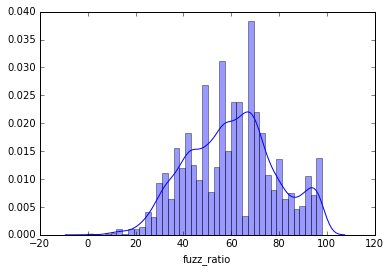

In [24]:
#look at the distribution of the fuzz_ratio
fuzz_dist = vessel_names[vessel_names.fuzz_ratio < 100]
sns.distplot(fuzz_dist.fuzz_ratio.dropna())

In [25]:
#determine number of words that are greater than or equal to 90
print sum(fuzz_ratio_90.fuzz_ratio >= 90), len(vessel_names)
print round(sum(fuzz_ratio_90.fuzz_ratio >= 90)/ (len(vessel_names) * 1.0),4)

733 9378
0.0782


** Just under 8% of vessel names might be mispellings of each other, we may want to adjust for this at a later point **
This does not account for cases where the beginning letters are different as these wouldn't be picked up in the sort, but it provide an indicator of the magnitude of the issue.

In [26]:
#get the new vessel names dataframe with whitespaces and punctutation removed
vessel_names_2 = vessel_names[['vessel_name','vessel_name_new']]

In [27]:
#merge vessel_names with original dataframe
df_orig_2014 = df_orig_2014.merge(vessel_names_2, left_on = 'vessel_name', right_on = 'vessel_name', how = "left")

In [28]:
df_orig_2014.rename(columns={'vessel_name': 'vessel_name_orig', 'vessel_name_new': 'vessel_name'}, inplace=True)

In [29]:
df_orig_2014.head()

,identifier,trade_update_date,run_date,vessel_name_orig,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,description_sequence_number,piece_count,description_text,carrier,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,vessel_name
0,2014082158845,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,1,7881,IKEA HOME FURNISHING PRODUCTS TARIFF NUMBER 44...,HYUNDAI,3,1,8,8,5,HYUNDAI FORCE
1,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5,HYUNDAI FORCE
2,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5,HYUNDAI FORCE
3,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5,HYUNDAI FORCE
4,2014082158983,2014-08-06,2014-08-21,OOCL SHENZHEN,"Long Beach, California",2014-08-19,"Yantian,China (Mainland)",New,"YANTIAN,CHINA",NaN,...,1,498,P.O.NO.050803/050938/051058/051197/051345/051 ...,OOCL,1,2,8,8,1,OOCL SHENZHEN


In [30]:
list(df_orig_2014)

['identifier',
 'trade_update_date',
 'run_date',
 'vessel_name_orig',
 'port_of_unlading',
 'estimated_arrival_date',
 'foreign_port_of_lading',
 'record_status_indicator',
 'place_of_receipt',
 'port_of_destination',
 'foreign_port_of_destination',
 'actual_arrival_date',
 'consignee_name',
 'shipper_party_name',
 'container_number',
 'description_sequence_number',
 'piece_count',
 'description_text',
 'carrier',
 'day_of_week_est',
 'day_of_week_act',
 'month_est',
 'month_act',
 'delay_days',
 'vessel_name']

** Get stats by vessel by month **

In [31]:
#get the unique counts
voyage_stats_all = df_orig_2014.groupby(['vessel_name','month_act']
          )['identifier','record_status_indicator','foreign_port_of_lading','port_of_unlading',
            'trade_update_date','run_date','estimated_arrival_date','actual_arrival_date',
            'container_number','consignee_name','shipper_party_name'].nunique()

#flatten the index to make it easier to work with
voyage_stats_all.reset_index(col_level=1,inplace = True)

In [32]:
voyage_stats_all.shape

(26084, 13)

In [33]:
#view voyage stats in descending order of the number of actual arrival dates per vessel per month
voyage_stats_all.sort_values('actual_arrival_date',ascending = False).head(10)

,vessel_name,month_act,identifier,record_status_indicator,foreign_port_of_lading,port_of_unlading,trade_update_date,run_date,estimated_arrival_date,actual_arrival_date,container_number,consignee_name,shipper_party_name
18588,OAKLAND EXPRESS,3,1013,2,7,8,50,30,40,21,1163,666,673
18364,NYK DEMETER,12,269,2,8,5,36,21,25,20,507,193,185
23839,TROPIC EXPRESS,5,77,2,2,1,20,18,17,18,651,53,43
18238,NYK APHRODITE,11,1386,2,15,4,59,28,18,17,1307,680,739
23841,TROPIC EXPRESS,7,53,2,3,1,20,16,17,17,725,33,34
649,ALIANCA EUROPA,12,76,2,2,14,24,15,28,17,76,43,49
642,ALIANCA EUROPA,4,30,2,1,10,13,14,15,17,30,14,23
18931,OOCL BRITAIN,12,1575,2,12,7,32,18,27,16,1318,722,859
19035,OOCL KUALA LUMPUR,11,1386,2,5,4,43,25,21,16,1313,598,673
13320,KOBE EXPRESS,12,376,2,9,9,44,20,30,16,499,243,234


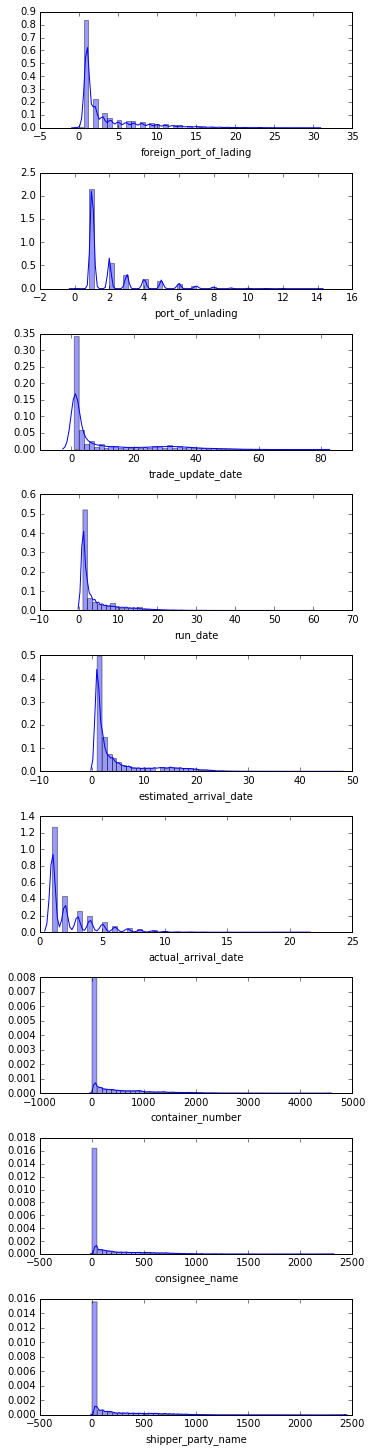

In [34]:
#view all distributions
n = 0
fig, axs = plt.subplots(nrows =9,figsize=(5,20))
for i,x in enumerate(list(voyage_stats_all)[4:]): 
    sns.distplot(voyage_stats_all[x], ax=axs[i])
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
#sns.regplot(x='value', y='wage', data=df_melt, ax=axs[1])
#sns.boxplot(x='education',y='wage', data=df_melt, ax=axs[2])

** View distributions of number of estimated and actual arrival date by vessel for each month **

- **actual arrival dates**: the average number of unique actual arrival dates is about 2 per vessel per month, about 32% of vessels have more than two actual arrival dates per month, and about 9% have more than 5.  On some routes it is possible that vessels can arrive two or more times at U.S. ports in a month, but this seems unlikely for most shipping routes.  This indicates a possible data integrity/data entry issue in the original system or at some point in the processing of this dataset. 
  
- **estimated arrival dates**: the average number of unique estimated arrival dates is about 5 per vessel per month, about 25% of vessels have more than five estimated arrival dates per month, and about 16% have more than 10. A scatter plot shows that while there is some increase in the number of estimated arrivals increases there is still a wide variation in estimated arrival dates vs. actual arrival dates. In cases with only arrival date there can be as many as 25 estimated arrival dates. This may indicates a possible data integrity/data entry issue in the original system or at some point in the processing of this dataset, and/or it indicates that shippers/consigners are being provided a wide range of dates for the same vessel voyage.  

- **arrival dates vs container volume**: the average number of unique actual arrival dates does not vary much with container volume; however the average number of unique estimated arrival dates increases somewhat with container volume.
  
- **This analysis will assume that enough of the data is accurate to build a model that can predict the arrival date given the estimated arrival date and other features.**

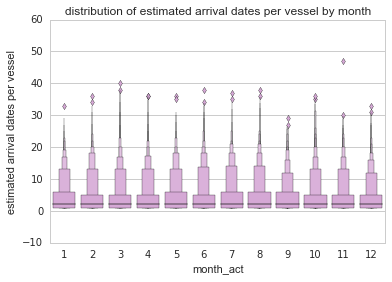

In [35]:
#view the distribution by month of estimated arrival dates
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_act", y="estimated_arrival_date", data=voyage_stats_all, color = 'plum')
ax.set_ylabel('estimated arrival dates per vessel')
ax.set_title('distribution of estimated arrival dates per vessel by month')
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

[(0, 60)]

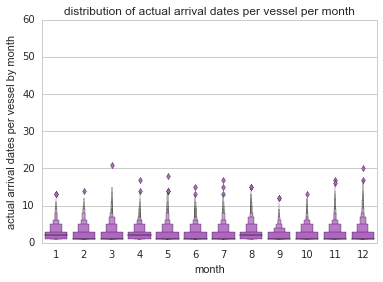

In [36]:
#view the distribution by month of actual arrival dates
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_act", y="actual_arrival_date", data=voyage_stats_all, color = 'mediumorchid')
ax.set_xlabel('month')
ax.set_ylabel('actual arrival dates per vessel by month')
ax.set_title('distribution of actual arrival dates per vessel per month')
ax.set(ylim=(0, 60))
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

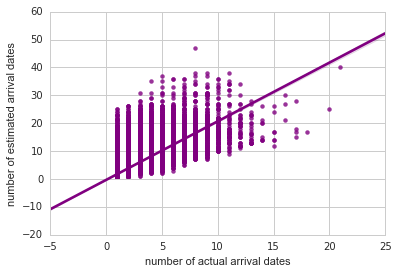

In [37]:
#Actual vs Estimated Arrival date scatter
#show the relationship with a scatter plot
ax = sns.regplot(x="actual_arrival_date", y="estimated_arrival_date", data=voyage_stats_all, color = 'purple')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('number of actual arrival dates')
ax.set_ylabel('number of estimated arrival dates')

** Compute the correlation between the number of arrival dates per ship and the number of containers per ship **

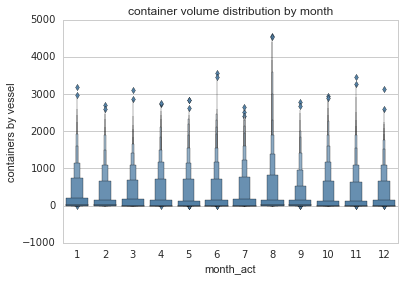

In [38]:
#view the distribution of containers per ship by month
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_act", y="container_number", data=voyage_stats_all, color = 'steelblue')
ax.set_ylabel('containers by vessel')
ax.set_title('container volume distribution by month')
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

In [39]:
#average actual arrival dates per vessel
print voyage_stats_all.actual_arrival_date.mean()

#arrivals per vessel
print len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 2]), len(voyage_stats_all)
print len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 2]) / (len(voyage_stats_all) * 1.0)

#arrivals per vessel
print len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 5]), len(voyage_stats_all)
print len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 5]) / (len(voyage_stats_all) * 1.0)

2.38889740837
8304 26084
0.318356080356
2289 26084
0.0877549455605


In [40]:
#average estimated arrival dates per vessel
print voyage_stats_all.estimated_arrival_date.mean()

#estimated arrivals per vessel
print len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 5]), len(voyage_stats_all)
print len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 5]) / (len(voyage_stats_all) * 1.0)

#estimated arrivals per vessel
print len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 10]), len(voyage_stats_all)
print len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 10]) / (len(voyage_stats_all) * 1.0)

4.69291519706
6474 26084
0.248198129121
4240 26084
0.162551755866


In [41]:
#Correlation between the number of actual_arrival_dates and number of containers per ship per month
voyage_stats_all['actual_arrival_date'].corr(voyage_stats_all['container_number'])

0.51754877626906881

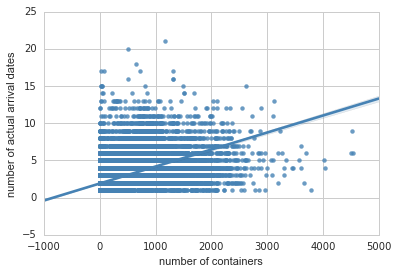

In [42]:
#show the relationship between volume and the number of actual arrival dates with a scatter plot
ax = sns.regplot(x="container_number", y="actual_arrival_date", data=voyage_stats_all, color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('number of containers')
ax.set_ylabel('number of actual arrival dates')

In [43]:
#Correlation between the number of estimated_arrival_dates and number of containers per ship per month
voyage_stats_all['estimated_arrival_date'].corr(voyage_stats_all['container_number'])

0.83899644632344317

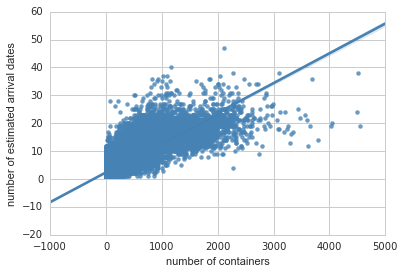

In [44]:
#show the relationship between volume and the number of estimated arrival dates with a scatter plot
ax = sns.regplot(x="container_number", y="estimated_arrival_date", data=voyage_stats_all, color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('number of containers')
ax.set_ylabel('number of estimated arrival dates')

** View the distribution of foreign port of lading and ports of unlading by month **

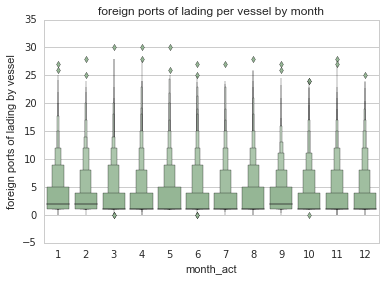

In [45]:
#view the distribution foreign ports of lading per ship by month
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_act", y="foreign_port_of_lading", data=voyage_stats_all, color = 'darkseagreen')
ax.set_ylabel('foreign ports of lading by vessel')
ax.set_title('foreign ports of lading per vessel by month')
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

[(0, 35)]

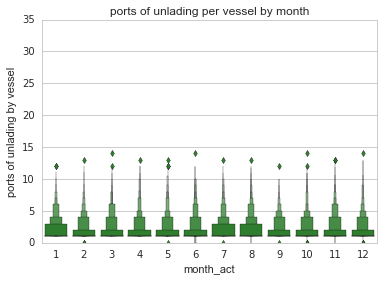

In [46]:
#view the distribution ports of unlading per ship by month
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_act", y="port_of_unlading", data=voyage_stats_all, color = 'forestgreen')
ax.set_ylabel('ports of unlading by vessel')
ax.set_title('ports of unlading per vessel by month')
ax.set(ylim=(0, 35))
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

** Review one ship that has a large number of actual_arrival_dates **

Observations:  
- actual arrival dates:
- estimated arrival dates:
- volume

In [47]:
#create a column subset of the dataframe to be used in the next step
df_orig_sub = df_orig_2014[['vessel_name','trade_update_date','run_date','estimated_arrival_date',
                            'actual_arrival_date','foreign_port_of_lading','port_of_unlading',
                            'record_status_indicator','month_act']]

In [48]:
vessel = 'OAKLAND EXPRESS'
month = 3
vessel_detail = df_orig_sub[(df_orig_sub.vessel_name.str.contains(vessel)) &
        (df_orig_sub.month_act == 3)].drop_duplicates().sort_values('actual_arrival_date')

In [49]:
vessel_detail.shape

(349, 9)

In [50]:
vessel_detail

,vessel_name,trade_update_date,run_date,estimated_arrival_date,actual_arrival_date,foreign_port_of_lading,port_of_unlading,record_status_indicator,month_act
8298585,OAKLAND EXPRESS,2014-02-14,2014-03-03,2014-02-14,2014-03-01,"Rotterdam,Netherlands","Los Angeles, California",New,3
6358046,OAKLAND EXPRESS,2014-02-20,2014-03-04,2014-02-16,2014-03-03,"Stadersand,Federal Republic of Germany","Oakland, California",New,3
6920014,OAKLAND EXPRESS,2014-02-10,2014-03-07,2014-02-25,2014-03-06,"Stadersand,Federal Republic of Germany","New York, New York",New,3
3755157,OAKLAND EXPRESS,2014-02-13,2014-03-07,2014-02-26,2014-03-06,"Stadersand,Federal Republic of Germany","New York, New York",New,3
8581183,OAKLAND EXPRESS,2014-02-06,2014-03-07,2014-02-19,2014-03-06,"Rotterdam,Netherlands","New York, New York",New,3
138300,OAKLAND EXPRESS,2014-02-18,2014-03-10,2014-02-26,2014-03-09,"Stadersand,Federal Republic of Germany","New York, New York",New,3
6085286,OAKLAND EXPRESS,2014-02-27,2014-03-10,2014-03-01,2014-03-09,"Anvers,Belgium","New York, New York",New,3
6085311,OAKLAND EXPRESS,2014-02-13,2014-03-10,2014-02-25,2014-03-09,"Rotterdam,Netherlands","New York, New York",New,3
2361693,OAKLAND EXPRESS,2014-02-27,2014-03-10,2014-03-02,2014-03-09,"Anvers,Belgium","New York, New York",New,3
2361664,OAKLAND EXPRESS,2014-02-13,2014-03-10,2014-03-01,2014-03-09,"Anvers,Belgium","New York, New York",New,3


** Create a modified 2014 file **

In [52]:
df_orig_2014.shape

(10680151, 25)

In [53]:
df_orig_2014.head()

,identifier,trade_update_date,run_date,vessel_name_orig,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,description_sequence_number,piece_count,description_text,carrier,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,vessel_name
0,2014082158845,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,1,7881,IKEA HOME FURNISHING PRODUCTS TARIFF NUMBER 44...,HYUNDAI,3,1,8,8,5,HYUNDAI FORCE
1,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5,HYUNDAI FORCE
2,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5,HYUNDAI FORCE
3,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5,HYUNDAI FORCE
4,2014082158983,2014-08-06,2014-08-21,OOCL SHENZHEN,"Long Beach, California",2014-08-19,"Yantian,China (Mainland)",New,"YANTIAN,CHINA",NaN,...,1,498,P.O.NO.050803/050938/051058/051197/051345/051 ...,OOCL,1,2,8,8,1,OOCL SHENZHEN


In [51]:
#write all data to a file
df_orig_2014.to_pickle('2014_data_V2.pkl')

** Create Los Angeles/Long Beach and Shanghai file**  
These are the largest U.S. ports by volume and the largest Chinese ports by volume

In [58]:
#create a dataframe where Los Angeles or Long Beach is the port of unlading 
#and Shanghai China is the foreign port of lading
df_LA_SH_2014 = df_orig_2014[(df_orig_2014.port_of_unlading.isin(['Los Angeles, California','Long Beach, California'])) &
              (df_orig_2014.foreign_port_of_lading.isin(['Shanghai ,China (Mainland)']))]

In [59]:
#check the shape
df_LA_SH_2014.shape

(658583, 25)

In [62]:
#check the resulting ports
df_LA_SH_2014.foreign_port_of_lading.unique(), df_LA_SH_2014.port_of_unlading.unique()

([Shanghai ,China (Mainland)]
 Categories (1, object): [Shanghai ,China (Mainland)],
 [Los Angeles, California, Long Beach, California]
 Categories (2, object): [Los Angeles, California, Long Beach, California])

In [63]:
#write all data to a file
df_LA_SH_2014.to_pickle('2014_data_LA_SH_V2.pkl')

**Read in Los Angeles/Long Beach and Shanghai subset file **

In [ ]:
df = pd.read_pickle('2014_data_LA_SH.pkl')

In [ ]:
#check that all rows imported
df.shape

In [ ]:
#check datatypes
df.dtypes

In [ ]:
df.head()

In [ ]:
list(df)

In [ ]:
#create a data frame with the fields that we will group often
df_sub = df[['trade_update_date','run_date','vessel_name','port_of_unlading','estimated_arrival_date',
 'foreign_port_of_lading', 'record_status_indicator','actual_arrival_date','consignee_name',
 'shipper_party_name','voyage','month_est']]

In [ ]:
#create a data frame with the fields that we will group often
df_sub2 = df[['trade_update_date','run_date','vessel_name','port_of_unlading','estimated_arrival_date',
 'foreign_port_of_lading', 'record_status_indicator','actual_arrival_date','voyage','month_est']]

** Get voyage stats by month, month will be a proxy for vessel voyage **
- Given the length of vessel voyages between China and California we would not expect to see the same vessel arrive more than once a month, with the possible exception of a vessel that arrives at the beginning of a month and then returns at the end of the month.

In [ ]:
#get the unique counts
voyage_stats = df.groupby(['vessel_name','month_est']
          )['identifier','record_status_indicator','foreign_port_of_lading','port_of_unlading',
            'trade_update_date','run_date','estimated_arrival_date','actual_arrival_date',
            'container_number','consignee_name','shipper_party_name'].nunique()

#flatten the index to make it easier to work with
voyage_stats.reset_index(col_level=1,inplace = True)

In [ ]:
voyage_stats.sort_values('actual_arrival_date', ascending = False).head()

In [ ]:
#view one of the vessel voyages with multiple actual_arrival_dates
df_sub[(df_sub.vessel_name.str.contains('OOCL KUALA LUMPUR'))& 
       (df_sub.port_of_unlading.str.contains('Los Angeles, California')) & 
       (df_sub.month_est == 11)
        ]['actual_arrival_date'].unique()

In [ ]:
#view the vessel data
df_sub2[(df_sub2.vessel_name.str.contains('OOCL KUALA LUMPUR')) &
        (df_sub2.month_est == 11)].drop_duplicates().sort_values('actual_arrival_date')[50:100]
#estimated arrival date looks much earlier - looks like it might have gone on an earlier shipment

In [ ]:
#view the vessel data
df_sub2[(df_sub2.vessel_name.str.contains('OOCL KUALA LUMPUR')) &
        (df_sub2.month_est == 11)].drop_duplicates().sort_values('actual_arrival_date')[50:100]
#estimated arrival date looks much earlier - looks like it might have gone on an earlier shipment

In [ ]:
#view the distribution of containers by month
sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

In [ ]:
#view the distribution by month of 
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_est", y="container_number", data=voyage_stats, color = 'steelblue')
ax.set_ylabel('containers by vessel')
ax.set_title('container volume distribution by month')
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

In [ ]:
#view the distribution by month of 
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_est", y="estimated_arrival_date", data=voyage_stats, color = 'plum')
ax.set_ylabel('estimated arrival dates per vessel')
ax.set_title('distribution of estimated arrival dates per vessel by month')
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

In [ ]:
#view the distribution by month of 
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_est", y="actual_arrival_date", data=voyage_stats, color = 'mediumorchid')
ax.set_xlabel('month')
ax.set_ylabel('actual arrival dates per vessel by month')
ax.set_title('distribution of actual arrival dates per vessel per month')
ax.set(ylim=(0, 25))
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

In [ ]:
#arrivals per vessel
print len(voyage_stats[voyage_stats.actual_arrival_date > 2]), len(voyage_stats)
print round(len(voyage_stats[voyage_stats.actual_arrival_date > 2])/ (len(voyage_stats) * 1.0),4)

** Problems Encountered **  
  
Data Cleaning Issues:   
- ship names are not clean - there are different spellings for the same ship
- there are errors in the data - non-2014 dates appear (this only 1% of the time and can be removed from the dataset)

Data Integrity Issues:  



** Consider using only vessels observations that have at most two actual arrival dates per month **


In [ ]:
#subset voyage stats to only vessels that had at most 2 actual arrival dates
voyage_stats2 = voyage_stats[voyage_stats.actual_arrival_date <= 2]

In [ ]:
#compare freight volumes percent of original remaining
round(voyage_stats2.container_number.sum() / (voyage_stats.container_number.sum() * 1.0),4)

This will drop 34% of the containers, which seems like too large a percentage to drop.

** Are there any correlations between the delay_days and any of the other possible features **

features: 
 'month_est',
 'day_of_week_est'
 'record_status_indicator',
 'consignee_name',
 'shipper_party_name',
 'description_sequence_number',
 'piece_count',
 'description_text',
 'delay_days']

In [ ]:
consignees = df[['container_number','consignee_name']].groupby([
    'consignee_name'],as_index = False).count().sort_values('container_number',ascending = False)

In [ ]:
consignees['containers'] = consignees.container_number
consignees.drop('container_number',1,inplace = True)

In [ ]:
consignees.head()

In [ ]:
consignees['top_consignee'] = np.where(consignees.containers/500 >= 1, 1, 0)

In [ ]:
consignees.head()

In [ ]:
df_features = df[['delay_days','trade_update_date', 'run_date', 'estimated_arrival_date','month_est', 
                  'day_of_week_est', 'record_status_indicator', 'consignee_name', 
                  'shipper_party_name', 'description_sequence_number', 'piece_count', 
                  'description_text']]

In [ ]:
df_features

In [ ]:
df_features = df_features.merge(consignees, left_on='consignee_name', right_on='consignee_name', how='left')

In [ ]:
df_features.drop('containers',1,inplace = True)

In [ ]:
df_features.head()

In [ ]:
df_features['top_consignee'] = np.where(df_features.top_consignee.isnull(), 0, df_features.top_consignee).astype(int)

In [ ]:
df_features.head()

In [ ]:
#one hot encode variables
#pd.get_dummies(df, prefix=['col1', 'col2'])
df_features = pd.get_dummies(df_features,columns=['record_status_indicator'])

In [ ]:
df_features.head()

In [ ]:
#drop record status deleted
df_features.drop('record_status_indicator_Deleted',1,inplace = True)

In [ ]:
#create a pairwise correlation matrix
df_corr = df_features.corr()

In [ ]:
df_corr

In [ ]:
df_corr[['delay_days']]

** Next Steps continue working on features **